In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow as tf

In [ ]:
gpu = 1

In [ ]:
devices = tf.config.experimental.get_visible_devices()

In [ ]:
devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
to_use = [d for d in devices if 'CPU' in d.name or f'GPU:{gpu}' in d.name]

In [ ]:
tf.config.experimental.set_visible_devices(to_use)
tf.config.experimental.set_memory_growth(to_use[-1], True)

In [ ]:
# export
from keras.models import Model
import keras.backend as K
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as res
import keras.applications.inception_v3 as inc
import keras.applications.xception as xce
from keras.applications.xception import preprocess_input as preproc_xce
from grade_classif.imports import *
from grade_classif.data.read import get_items
from grade_classif.data.dataset import ImageClassifDataset
from grade_classif.params.parser import hparams
from grade_classif.data.utils import show_img

## Concept classes dataframe

In [ ]:
garb = [38743,
        38778,
        38792,
        38797,
        39304,
        40288,
        40290]

In [ ]:
ok = [40749,
      41149,
      41177,
      41289,
      41509,
      41587,
      41591,
      41796,
      42728,
      42886,
      43439,
      44344,
      44455]

In [ ]:
K = [42886,
     41591,
     41149,
     41509,
     40749]

In [ ]:
K_moins = [43439,
           41796]

In [ ]:
K_inter = [44455,
           41587]

In [ ]:
out = [44344,
       41177,
       42728,
       41289]

In [ ]:
d = {i: 'K' for i in K}

In [ ]:
d.update({i: 'K_moins' for i in K_moins})

In [ ]:
d.update({i: 'K_inter' for i in K_inter})

In [ ]:
d.update({i: 'out' for i in out})

In [ ]:
d.update({i: 'garb' for i in garb})

In [ ]:
conc_classes_df = pd.DataFrame({'type': d})

In [ ]:
conc_classes_df

type
38743     garb
38778     garb
38792     garb
38797     garb
39304     garb
40288     garb
40290     garb
40749        K
41149        K
41177      out
41289      out
41509        K
41587  K_inter
41591        K
41796  K_moins
42728      out
42886        K
43439  K_moins
44344      out
44455  K_inter

In [ ]:
# conc_classes_df.to_csv(hparams.concept_classes)

## Extractor

In [ ]:
# export
class Extractor:

    def __init__(self, cnn_architecture="xception", layer="output", patchsize=299):

        self.network_name = cnn_architecture
        self.layer_name = layer

        self.get_network_characteristics(patchsize)

        print("Feature extractor: %s // %s" % (self.network_name, self.layer_name))

    def get_network_characteristics(self, patchsize):

        if self.network_name == "vgg16":

            base_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "vgg19":
            base_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "resnet":
            base_model = res.ResNet50(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "xception":
            base_model = xce.Xception(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "inception":
            base_model = inc.InceptionV3(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        else:
            print("Error: possible network names:\n-'vgg16'\n-'vgg19'\n-'resnet'\n-'xception'\n-'inception'")

    def extract(self, images):
        features = self.model.predict(preproc_xce(images))
        return np.array([np.ndarray.flatten(f) for f in features])

    def load_weights(self, weight_path):
        self.model.load_weights(weight_path)
        print("Loaded weights from: {}".format(weight_path))

In [ ]:
extractor = Extractor()

Feature extractor: xception // output


In [ ]:
extractor.load_weights('/data/DeepLearning/ABREU_Arnaud/PUL/NST/xception/niv1_test2/weights/iter_12.h5')

Loaded weights from: /data/DeepLearning/ABREU_Arnaud/PUL/NST/xception/niv1_test2/weights/iter_12.h5


In [ ]:
centroids_df = pd.read_csv('/data/DeepLearning/ABREU_Arnaud/NST_PACS/WS_Clustering/SlidesMining/28_10_2019/most_significant_descriptor.csv')

In [ ]:
concepts = []
vectors = []
for k, row in centroids_df.iterrows():
    conc = int(row['Concept'])
    if conc in garb+ok:
        concepts.append(conc)
        vectors.append(row.values[1:])

In [ ]:
concepts = np.array(concepts)

In [ ]:
vectors = np.expand_dims(vectors, 0)

## Loading data

In [ ]:
hparams.full_data = hparams.full_data.parent/'Patches_1024'
hparams.data = hparams.full_data/'Patches_1024_1'
hparams.size = 1024

In [ ]:
data, labels = get_items(hparams.full_data.parent/'Patches_1024/Patches_1024_1', lambda x: x.parts[-3], extensions=['.png'])

In [ ]:
data = np.array(data)
labels = np.array(labels)

## Basic clustering

In [ ]:
batch = []
scores = []
for fn in tqdm(data, total=len(data)):
    x = cv2.imread(str(fn), cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    batch.append(cv2.resize(x, (299, 299), cv2.INTER_LINEAR))       
    if len(batch)==16:
        batch = np.stack(batch)
        fts = np.expand_dims(extractor.extract(batch), 1)
        scores.append(((vectors-fts)**2).sum(-1))
        batch = []
if len(batch) > 0:
        batch = np.stack(batch)
        fts = np.expand_dims(extractor.extract(batch), 1)
        scores.append(((vectors-fts)**2).sum(-1))
scores = np.concatenate(scores)

100%|██████████| 17592/17592 [03:37<00:00, 81.00it/s] 


In [ ]:
np.save(hparams.data/'distances.npy', scores)

In [ ]:
np.save(hparams.data/'items.npy', np.array(data))

In [ ]:
best_idxs = np.argmin(scores, axis=-1)

In [ ]:
best_concepts = concepts[best_idxs]

In [ ]:
conc_df = pd.DataFrame({'patchId': list(map(lambda x: x.stem, data)), 'concept': best_concepts})

In [ ]:
conc_df.to_csv(hparams.data/'concepts.csv', index=False)

In [ ]:
items = data[np.isin(best_concepts, garb)]

In [ ]:
K_labels = labels[np.isin(best_concepts, K)]

In [ ]:
(K_labels == '3').astype('float').sum()/(K_labels == '1').astype('float').sum()

0.0

  0%|          | 0/100 [00:00<?, ?it/s]


error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


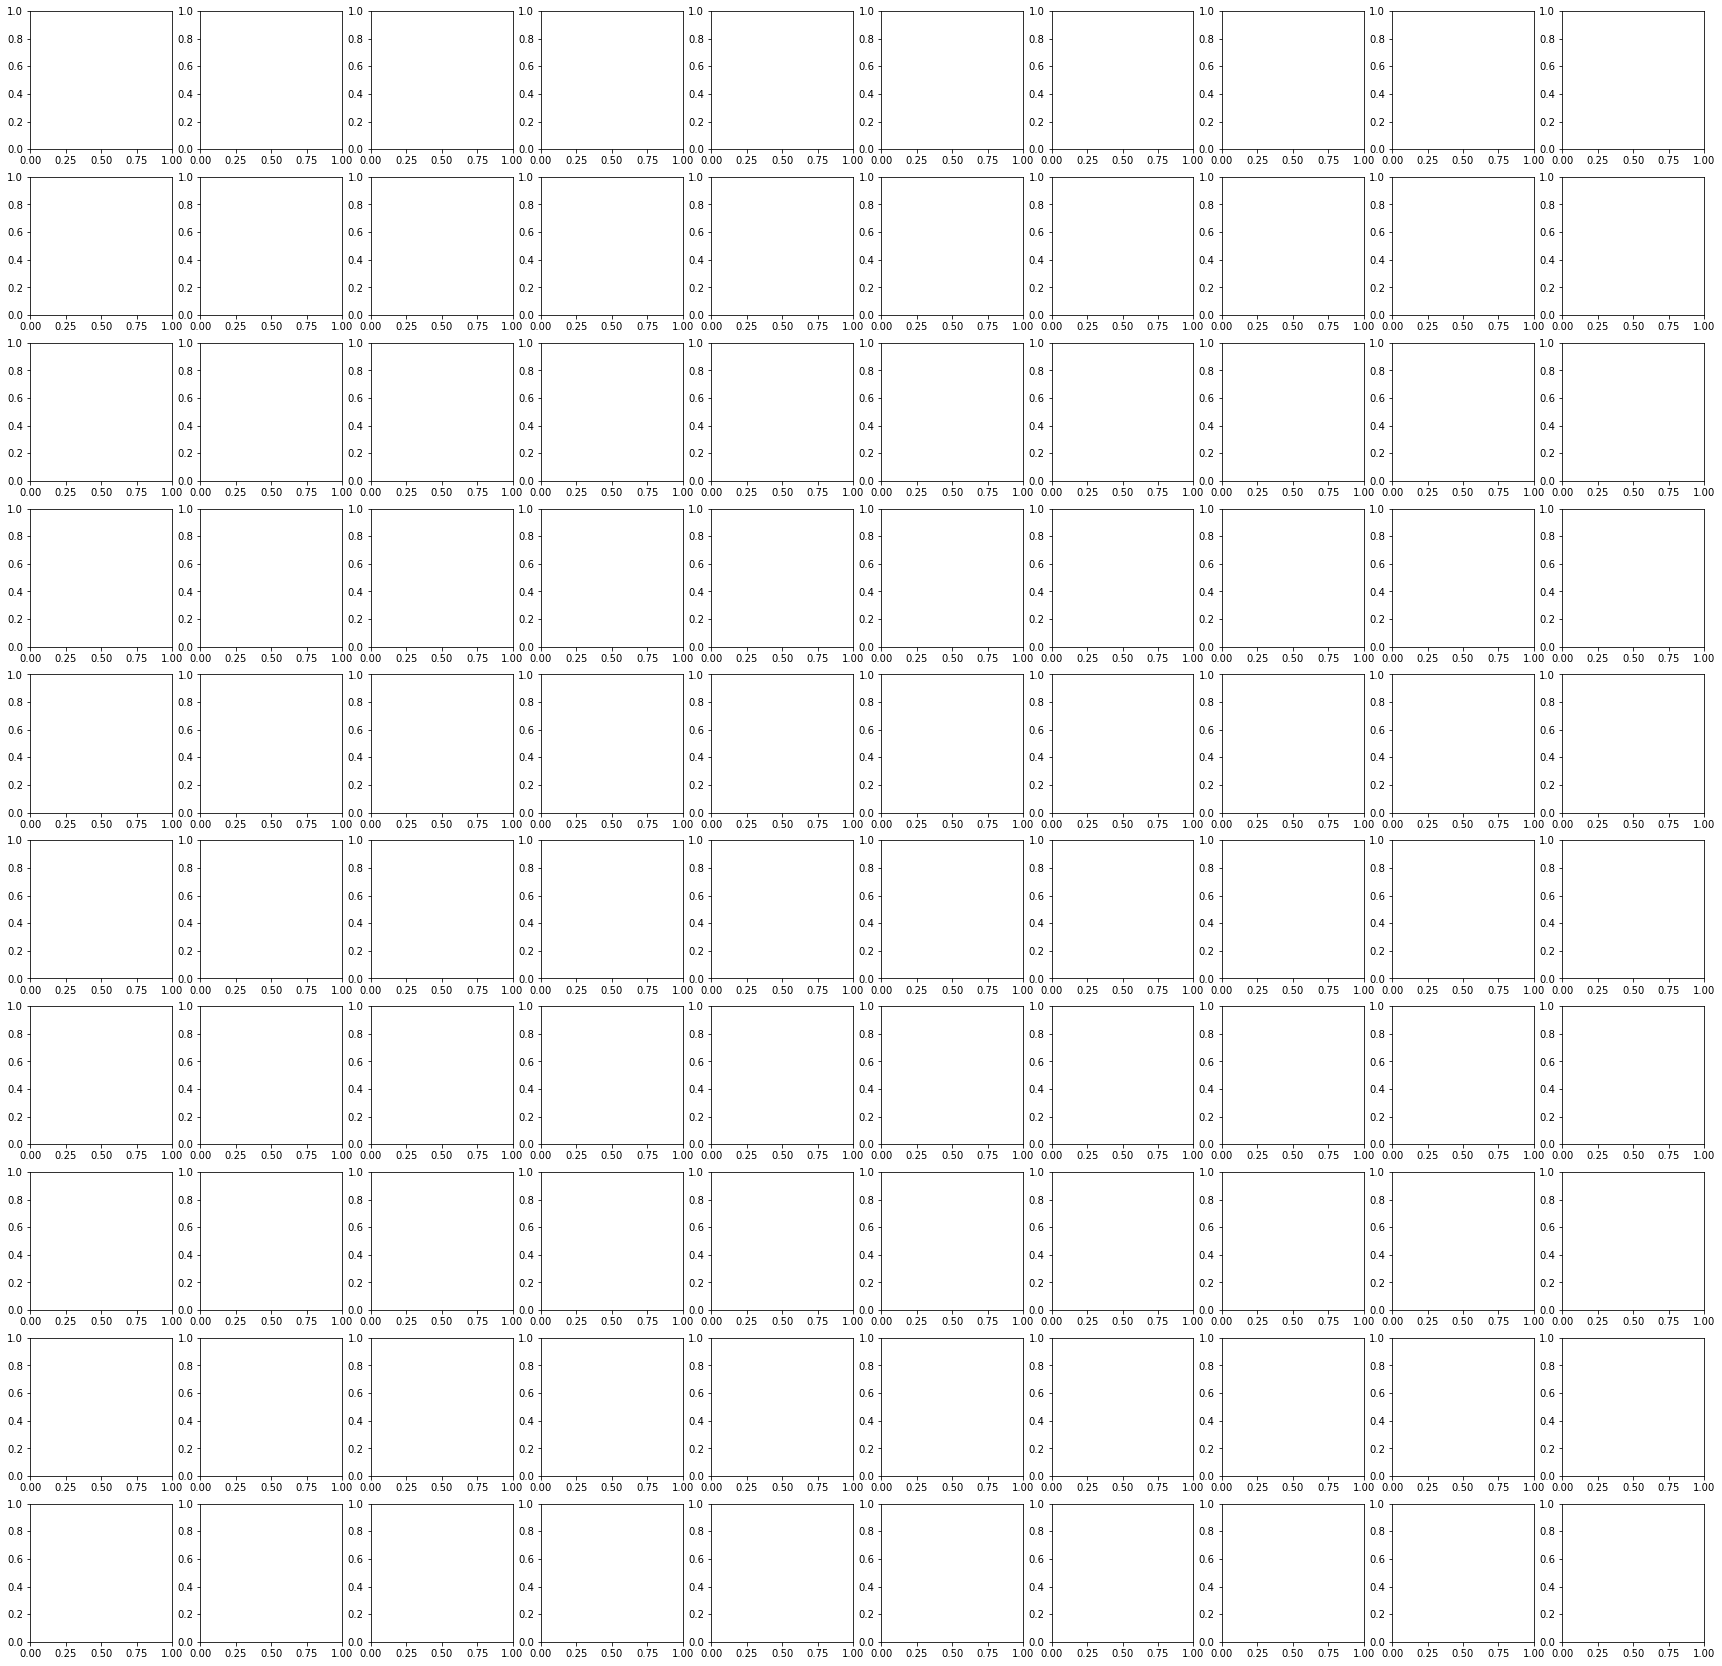

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))
for ax in tqdm(axs.flatten()):
    fn = np.random.choice(items)
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')

## Tile clustering

In [ ]:
scores = []
for fn in tqdm(data, total=len(data)):    
    x = cv2.imread(str(fn), cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    batch = [x[i*181: i*181+299, j*181: j*181+299] for i in range(4) for j in range(4)]
    batch = np.stack(batch)
    fts = np.expand_dims(extractor.extract(batch), 1)
    scores.append(((vectors-fts)**2).sum(-1))
scores = np.concatenate(scores)

100%|██████████| 629988/629988 [31:11:19<00:00,  5.61it/s]   


In [ ]:
np.save(hparams.data/'distances.npy', scores)

In [ ]:
np.save(hparams.data/'items.npy', np.array(data))

In [ ]:
best_idxs = np.argmin(scores, axis=-1)

In [ ]:
best_concepts = concepts[best_idxs]

garb 0.0
K 0.0
out 0.8125
K_inter 0.1875
K_moins 0.0


(-0.5, 1023.5, 1023.5, -0.5)

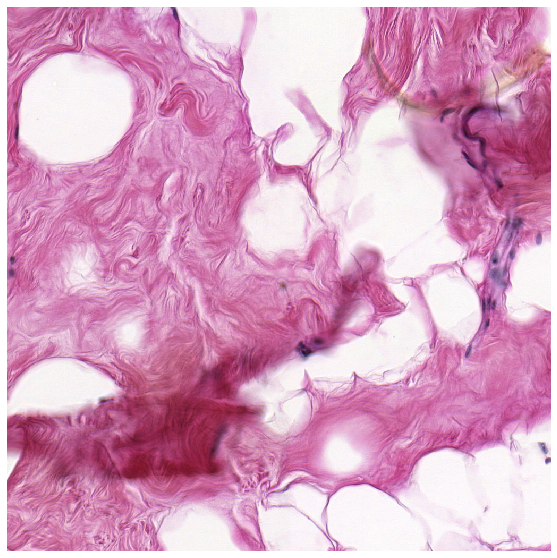

In [ ]:
k = np.random.randint(len(data))
concs = best_concepts[k*16:(k+1)*16]
unique_concs = np.unique(concs)
stats = (concs[None] == unique_concs[:, None]).sum(-1)/16
for c in conc_classes_df['type'].unique():
    idxs = np.argwhere(np.isin(unique_concs, conc_classes_df.loc[conc_classes_df['type']==c].index))
    print(c, stats[idxs].sum())
img = cv2.imread(str(data[k]), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')

In [ ]:
best_concepts = best_concepts.reshape((-1, 16))

In [ ]:
type_scores = np.zeros_like(best_concepts, dtype=object)
types = conc_classes_df['type'].unique()
for k, c in enumerate(conc_classes_df['type'].unique()):
    type_scores[:, k] = np.isin(best_concepts, conc_classes_df.loc[conc_classes_df['type']==c].index).sum(-1)/16

In [ ]:
best_types = types[type_scores.argmax(-1)]
best_scores = type_scores.max(-1)

In [ ]:
t = 'out'
idxs = np.argwhere((best_types == t)).squeeze(1)

In [ ]:
len(idxs)/len(data), len(idxs), (labels[idxs]=='1').sum()/len(labels[idxs])

(0.36189578214188206, 227990, 0.7877012149655687)

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


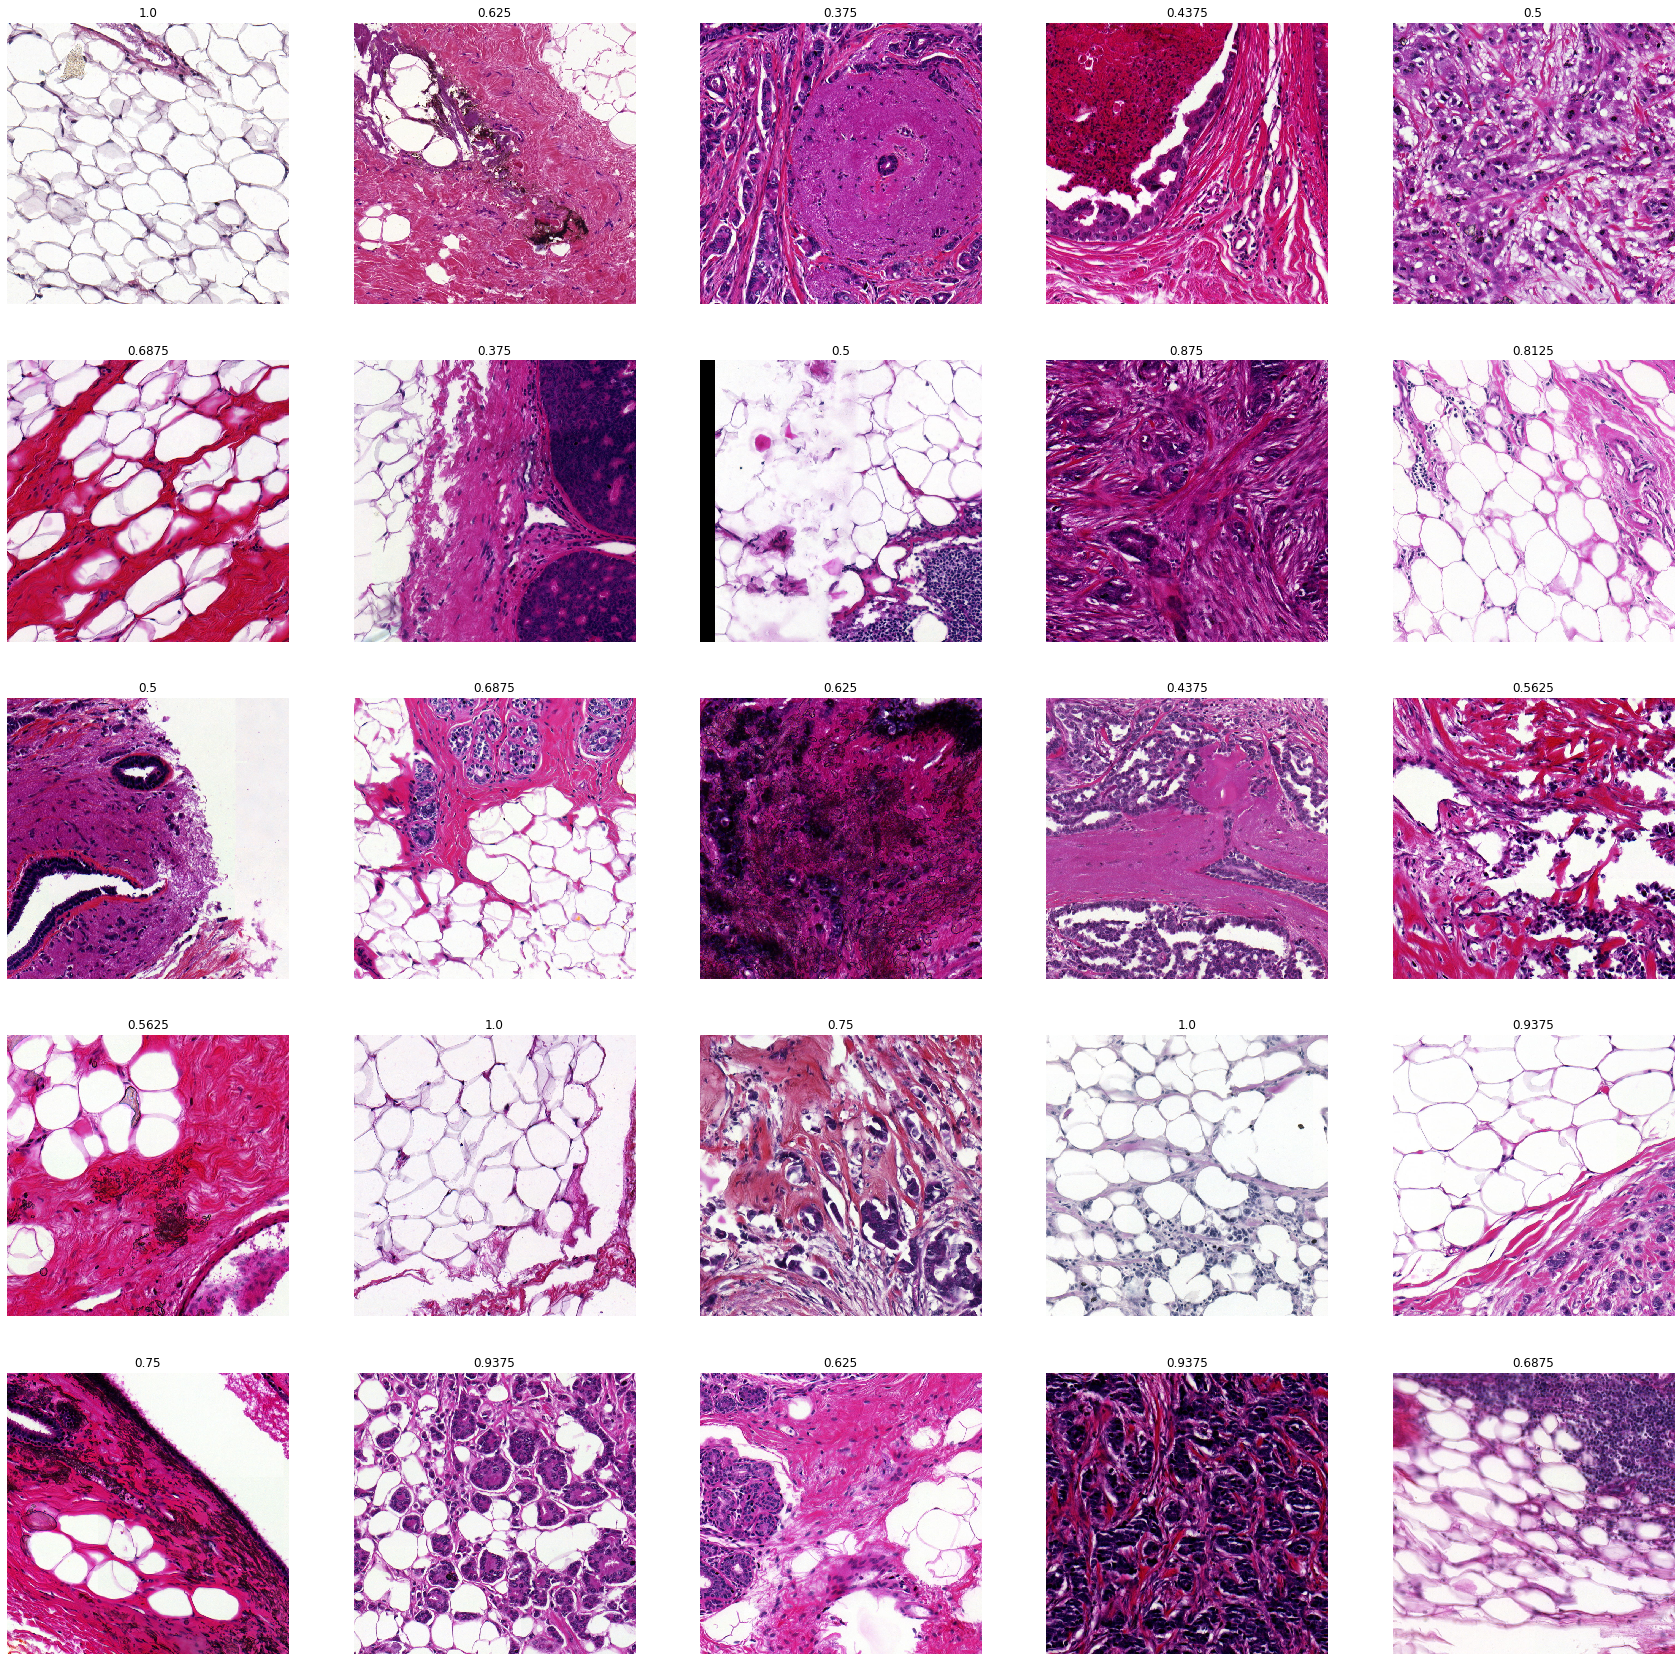

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for ax in tqdm(axs.flatten()):
    k = np.random.choice(idxs)        
    fn = data[k]
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.set_title(best_scores[k])
    ax.imshow(img)
    ax.axis('off')

In [ ]:
patches_df = pd.DataFrame({'patchId': list(map(lambda x: x.stem, data)), 'type': best_types})

In [ ]:
patches_df.to_csv(hparams.data/'patch_classes.csv', index=False)

## Few stats

In [ ]:
from grade_classif.params.parser import hparams
from grade_classif.data.dataset import ImageClassifDataset
conc_df = pd.read_csv(hparams.data/'concepts.csv')
data = ImageClassifDataset.from_folder(hparams.data, lambda x: x.parts[-3], include=['1', '3'], classes=['1', '3'])

In [ ]:
scans_df = pd.read_csv(hparams.full_data/'scans.csv')

In [ ]:
concept = conc_df['concept'].unique()[2]; concept

39304

In [ ]:
for concept in conc_df['concept'].unique():
    print(concept, conc_df.loc[conc_df['concept']==concept].shape[0])

41289 1926
44455 4027
41509 484
41177 3416
44344 1336
41796 589
42886 421
42728 3253
41149 436
41591 225
40290 400
41587 432
40749 385
43439 211
39304 9
40288 40
38797 2


In [ ]:
stats = df.groupby(lambda x: df['patchId'][x][7:9])

In [ ]:
res={}
for group in stats.groups:
    pacs_df = df.loc[stats.groups[group]]
    print(group, pacs_df.shape[0]/df.shape[0])
    res[group] = {}
    for concept in df['concept'].unique():
        pacs_df.loc[pacs_df['concept']==concept].shape[0]
        res[group][concept] = pacs_df.loc[pacs_df['concept']==concept].shape[0]/df.loc[df['concept']==concept].shape[0]

04 0.47017038684239504
05 0.19475740378246628
08 0.33507220937513865


In [ ]:
df_no_garb = df.loc[df['concept'].isin(ok)]

In [ ]:
stats_no_garb = df_no_garb.groupby(lambda x: df_no_garb['patchId'][x][7:9])

In [ ]:
for group in stats_no_garb.groups:
    pacs_df = df_no_garb.loc[stats_no_garb.groups[group]]
    print(group, pacs_df.shape[0]/df_no_garb.shape[0])

04 0.4851155238906314
05 0.19838467343815994
08 0.3164998026712087


In [ ]:
stats_scans = scans_df.groupby(lambda x: scans_df['scan'][x][7:9])

In [ ]:
for group in stats_scans.groups:
    pacs_df = scans_df.loc[stats_scans.groups[group]]
    print(group, pacs_df.shape[0]/scans_df.shape[0])

04 0.5013333333333333
05 0.20444444444444446
08 0.2942222222222222


In [ ]:
pd.DataFrame(res).to_csv(hparams.data/'stats.csv')